In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
# import modin.pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gzip

In [5]:
#Reading data
# train = pd.read_csv('sales_train.csv.gz', compression='gzip')
# test = pd.read_csv('test.csv.gz', compression='gzip')
item_categories = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')

In [3]:
print(item_categories.shape)
print(item_categories.isnull().any())
item_categories.head()

(84, 2)
item_category_name    False
item_category_id      False
dtype: bool


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [4]:
print(items.shape)
print(items.isnull().any())
items.head()

(22170, 3)
item_name           False
item_id             False
item_category_id    False
dtype: bool


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
print(shops.shape)
print(shops.isnull().any())
shops.head()

(60, 2)
shop_name    False
shop_id      False
dtype: bool


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
print(train.shape)
print(train.isnull().any())
train.head()

(2935849, 6)
date              False
date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
dtype: bool


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]


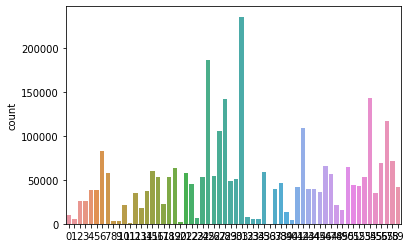

In [7]:
print(train['date_block_num'].unique())
sns.countplot(train['shop_id'].values)
plt.show()

In [8]:
print(test.shape)
print(test.isnull().any())
test.head()

(214200, 3)
ID         False
shop_id    False
item_id    False
dtype: bool


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [9]:
test['shop_id'].unique()

array([ 5,  4,  6,  3,  2,  7, 10, 12, 28, 31, 26, 25, 22, 24, 21, 15, 16,
       18, 14, 19, 42, 50, 49, 53, 52, 47, 48, 57, 58, 59, 55, 56, 36, 37,
       35, 38, 34, 46, 41, 44, 39, 45], dtype=int64)

In [10]:
train.loc[:,['item_price','item_cnt_day']].describe()

,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06
mean,8.908532e+02,1.242641e+00
std,1.729800e+03,2.618834e+00
min,-1.000000e+00,-2.200000e+01
25%,2.490000e+02,1.000000e+00
50%,3.990000e+02,1.000000e+00
75%,9.990000e+02,1.000000e+00
max,3.079800e+05,2.169000e+03


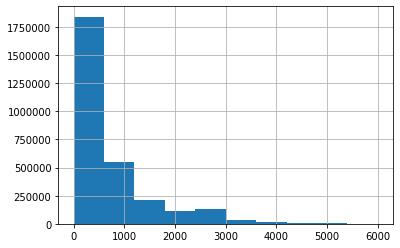

In [11]:
train.loc[(train['item_price']<np.quantile(train['item_price'],0.99))&(train['item_price']>0),'item_price'].hist()
plt.show()

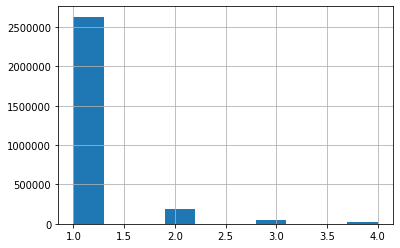

In [12]:
train.loc[(train['item_cnt_day']<np.quantile(train['item_cnt_day'],0.99))&(train['item_cnt_day']>0),'item_cnt_day'].hist()
plt.show()

In [13]:
f1 = (train['item_price']<np.quantile(train['item_price'],0.99)) & (train['item_price']>0)
f2 = (train['item_cnt_day']<np.quantile(train['item_cnt_day'],0.99)) & (train['item_cnt_day']>0)
train = train.loc[f1 & f2,:]
train['date'] = pd.to_datetime(train['date'],format="%d.%m.%Y")
train['month'] = train['date'].apply(lambda x: x.month)

In [14]:
sum(item_categories.groupby('item_category_name').agg('count')['item_category_id']>1)
sum(items.groupby('item_name').agg('count')['item_id']>1)
sum(shops.groupby('shop_name').agg('count')['shop_id']>1)

0

In [15]:
train = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_price':'mean','month':'mean','item_cnt_day':'sum'})
train.reset_index(inplace=True)
train.rename(columns = {'item_cnt_day':'item_cnt_month'},inplace=True)

In [16]:
train = train.merge(items,on='item_id',how='left')
train.drop('item_name',axis=1,inplace=True)

In [19]:
# #Not used
# def lag(row,col,n):
#     date_block_num = int(row['date_block_num']-n)
#     shop_id = int(row['shop_id'])
#     item_id = int(row['item_id'])
#     f = (train['date_block_num']==date_block_num) & (train['shop_id']==shop_id) & (train['item_id']==item_id)
#     if date_block_num<0:
#         return None
#     elif train.loc[f,:].shape[0]!=0:
#         return int(train.loc[f,col])
#     else:
#         return 0
    
# train['item_cnt_month_lag_1'] = train.apply(lambda x: lag(x,'item_cnt_month',1),axis=1)

In [124]:
#Creating all items with 0 count for all shops
for i in range(60):
    for j in range(34):
        itemi = items.copy()
        itemi['shop_id'] = i
        itemi['date_block_num'] = j
        itemi.drop(['item_name','item_category_id'],inplace=True,axis=1)
        train = train.merge(itemi,on=['date_block_num','shop_id','item_id'],how='outer')   

In [12]:
train.to_csv('sales_train_v1.csv')
# train.to_pickle("sales_train_v1.pkl")

In [2]:
train = pd.read_csv('sales_train_v1.csv')
if 'Unnamed: 0' in train.columns:
    train.drop('Unnamed: 0',axis=1,inplace=True)

In [9]:
# #If pickle is read, run following
# train = train.merge(items,on='item_id',how='left')
# train.drop('item_name',axis=1,inplace=True)
# train.loc[pd.isnull(train['month']),'month'] = (train.loc[pd.isnull(train['month']),'date_block_num']+1)%12
# train.loc[train['month']==0,'month'] = 12
# train.loc[pd.isnull(train['item_cnt_month']),'item_cnt_month'] = 0

In [11]:
def lag(df,col,n):
    t = df.copy()
    t = t.loc[:,['date_block_num','shop_id','item_id',col]]
    t['date_block_num'] = t['date_block_num']+n
    df = df.merge(t,on=['date_block_num','shop_id','item_id'],how='left')
    df.rename(columns = {col+'_x':col,col+'_y':col+'_lag_'+str(n)},inplace=True)
    return df

In [9]:
# train = lag(train,'item_cnt_month',1)
# train = lag(train,'item_cnt_month',2)
# train = lag(train,'item_cnt_month',6)
# train = lag(train,'item_cnt_month',12)

In [12]:
train['item_cnt_month_3block_avg'] = np.nan
train.loc[train['date_block_num']>1,'item_cnt_month_3block_avg'] = (train['item_cnt_month']+train['item_cnt_month_lag_1']+\
                                                                    train['item_cnt_month_lag_2'])/3

In [4]:
train.tail()

,date_block_num,shop_id,item_id,item_price,month,item_cnt_month,item_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_6,item_cnt_month_lag_12,item_cnt_month_3block_avg,item_price_lag_1,item_category
45226795,33,59,22165,449.0,10.0,0.0,31,0.0,0.0,0.0,0.0,0.0,499.0,Игры
45226796,33,59,22166,449.0,10.0,0.0,54,0.0,0.0,0.0,0.0,0.0,499.0,Книги
45226797,33,59,22167,449.0,10.0,0.0,49,0.0,0.0,0.0,0.0,0.0,499.0,Книги
45226798,33,59,22168,449.0,10.0,0.0,62,0.0,0.0,0.0,0.0,0.0,499.0,Подарки
45226799,33,59,22169,449.0,10.0,0.0,69,0.0,0.0,0.0,0.0,0.0,499.0,Подарки


In [5]:
train_price = train.groupby(['date_block_num','shop_id']).agg('median')['item_price']
train_price = train_price.reset_index()
train_price.rename(columns = {'item_price':'item_price_median'},inplace=True)
train = train.merge(train_price,on=['date_block_num','shop_id'],how='left')
train.loc[pd.isnull(train['item_price']),'item_price'] = train.loc[pd.isnull(train['item_price']),'item_price_median']
train.drop('item_price_median',axis=1,inplace=True)

,date_block_num,shop_id,item_price_median
0,0,0,193.0
1,0,1,190.0
2,0,2,399.0
3,0,3,399.0
4,0,4,299.0


In [12]:
train = lag(train,'item_price',1)

In [36]:
item_categories['item_category_name'] = item_categories['item_category_name'].apply(lambda x: x.split()[0])
train = train.merge(item_categories,on='item_category_id',how='left')
train.rename(columns = {'item_category_name':'item_category'},inplace=True)

In [6]:
shops['shop_name'] = shops['shop_name'].apply(lambda x: x.split()[0])
train = train.merge(shops,on='shop_id',how='left')
train.rename(columns = {'shop_name':'shop_category'},inplace=True)

In [7]:
train['shop_id'] = train['shop_id'].apply(lambda x: str(x))
train['item_id'] = train['item_id'].apply(lambda x: str(x))
train['item_category_id'] = train['item_category_id'].apply(lambda x: str(x))

In [10]:
train.head()

,date_block_num,shop_id,item_id,item_price,month,item_cnt_month,item_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_6,item_cnt_month_lag_12,item_cnt_month_3block_avg,item_price_lag_1,item_category,shop_category
0,0,0,32,221.0,1.0,6.0,40,NaN,NaN,NaN,NaN,NaN,NaN,Кино,!Якутск
1,0,0,33,347.0,1.0,3.0,37,NaN,NaN,NaN,NaN,NaN,NaN,Кино,!Якутск
2,0,0,35,247.0,1.0,1.0,40,NaN,NaN,NaN,NaN,NaN,NaN,Кино,!Якутск
3,0,0,43,221.0,1.0,1.0,40,NaN,NaN,NaN,NaN,NaN,NaN,Кино,!Якутск
4,0,0,51,128.5,1.0,2.0,57,NaN,NaN,NaN,NaN,NaN,NaN,Музыка,!Якутск
